In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import tensorflow as tf
import pickle
from pathlib import Path
from dataclasses import dataclass
from mbeml.constants import LigandFeatures, TargetProperty
from mbeml.featurization import data_prep
from mbeml.plotting import color_dict, marker_dict, core_legend, scatter_random_z

In [2]:
plt.style.use("mbeml.mbeml")

In [3]:
data_dir = Path("../../data/")

df_lig_test = pd.read_csv(data_dir / "ligand_test_data.csv")

model_dir = Path("../../models/")

In [4]:
@dataclass
class Experiment:
    name: str
    features: LigandFeatures
    target: TargetProperty = TargetProperty.SSE
    is_nn: bool = False
    prediction = np.zeros(len(df_lig_test))
    uncertainty = np.zeros(len(df_lig_test))

In [5]:
krr_experiments = [
    Experiment("krr_standard_racs", features=LigandFeatures.STANDARD_RACS),
    Experiment("krr_two_body", features=LigandFeatures.LIGAND_RACS),
    Experiment("krr_three_body", features=LigandFeatures.LIGAND_RACS),
]
nn_experiments = [
    Experiment("nn_standard_racs", features=LigandFeatures.STANDARD_RACS, is_nn=True),
    Experiment("nn_two_body", features=LigandFeatures.LIGAND_RACS, is_nn=True),
    Experiment("nn_three_body", features=LigandFeatures.LIGAND_RACS, is_nn=True),
]
experiments = krr_experiments + nn_experiments

In [6]:
for experiment in krr_experiments + nn_experiments:
    x, _ = data_prep(
        df_lig_test, experiment.features, experiment.target, experiment.is_nn
    )
    # Evaluate model
    if experiment.is_nn:
        model = tf.keras.models.load_model(
            model_dir / experiment.target.name.lower() / experiment.name
        )
        experiment.prediction, experiment.uncertainty = model.predict(x, verbose=0)
    else:
        with open(
            model_dir / experiment.target.name.lower() / f"{experiment.name}.pkl",
            "rb",
        ) as fin:
            model = pickle.load(fin)
        y_mean, y_std = model.predict(x, return_std=True)
        experiment.prediction = y_mean.reshape(-1, 1)
        experiment.uncertainty = y_std.reshape(-1, 1)

2024-02-15 10:26:35.069894: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


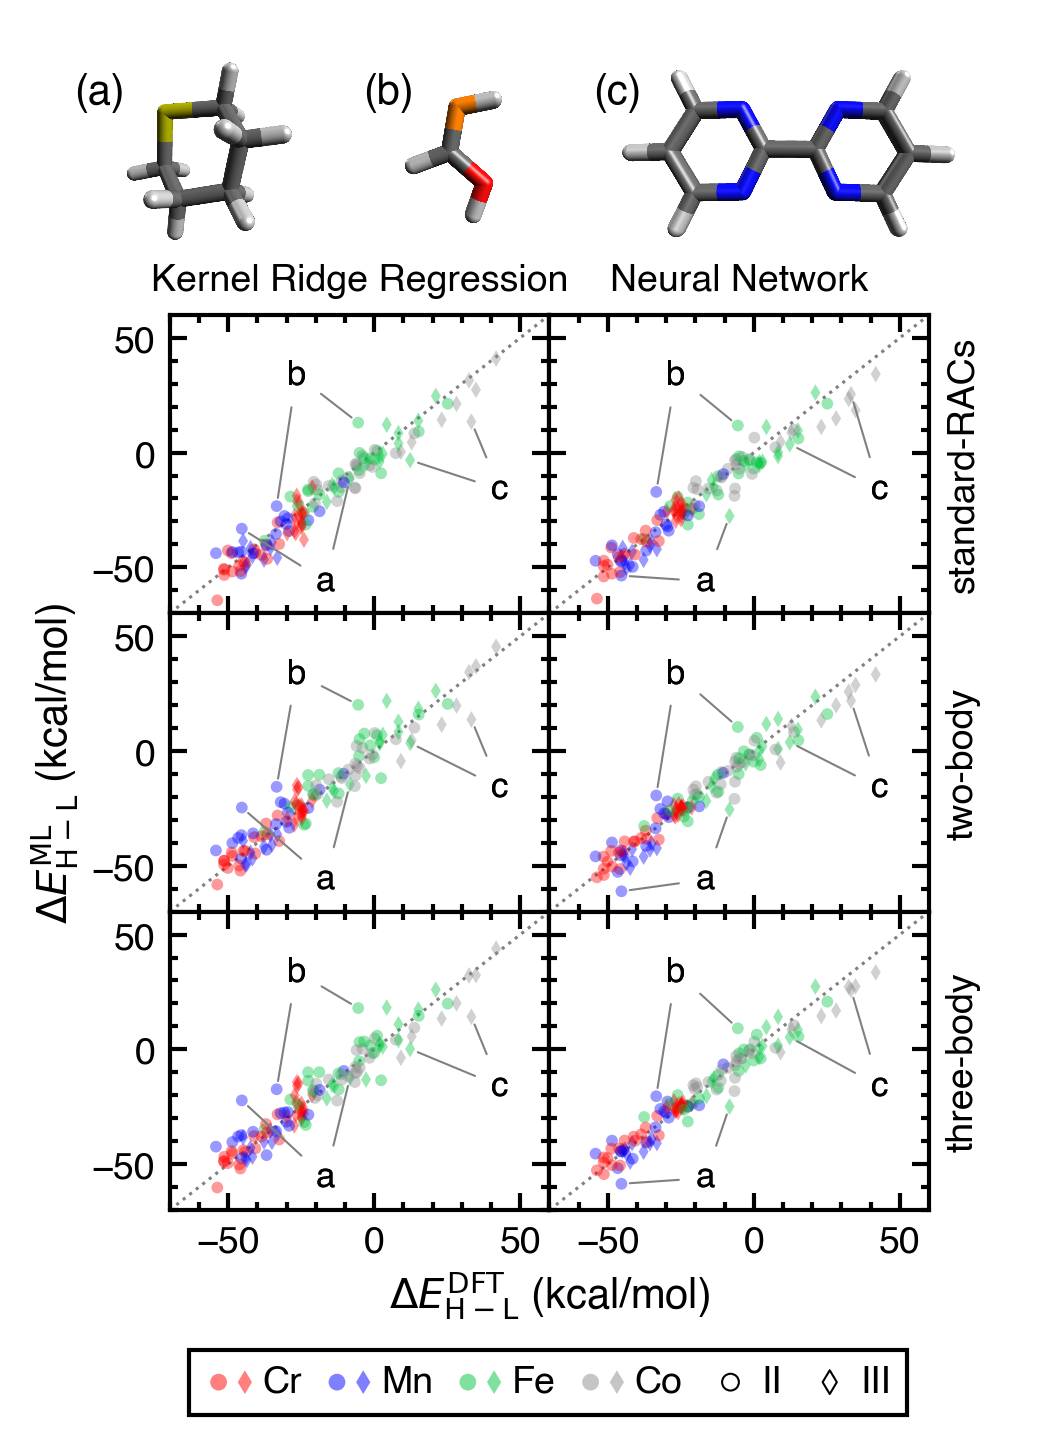

In [7]:
_, y = data_prep(df_lig_test, LigandFeatures.STANDARD_RACS, TargetProperty.SSE, False)
cores = df_lig_test[["metal", "ox"]].apply(lambda x: f"{x.metal}{x.ox}", axis=1).values

figsize = (3.33, 1.4 * 3.33)
fig = plt.figure(figsize=figsize)

alternative_plots = False
if alternative_plots:
    insets = [
        ("a", "plots/thiane_alt.png", 0.15, 0.5),
        ("b", "plots/[PH]=[CH]-[OH]_alt.png", 0.15, 0.4),
        ("c", "plots/bipyrimidine_alt.png", 0.25, 0.5),
    ]
else:
    insets = [
        ("a", "plots/thiane.png", 0.066, 0.5),
        ("b", "plots/[PH]=[CH]-[OH].png", 0.045, 0.5),
        ("c", "plots/bipyrimidine.png", 0.074, 0.5),
    ]
insert_axes = fig.subplots(
    ncols=3,
    nrows=1,
    gridspec_kw={
        "left": 0.05,
        "right": 1.0,
        "top": 0.98,
        "bottom": 0.85,
        "hspace": 0.0,
        "wspace": 0.0,
    },
    width_ratios=[2.0, 1.5, 3],
)
for i, (s, path, scale, center_y) in enumerate(insets):
    ax = insert_axes[i]
    ax.text(0.05, 0.95, f"({s})", fontsize="medium", ha="left", va="top")
    im = mpimg.imread(path)
    imagebox = OffsetImage(im, zoom=scale)
    ab = AnnotationBbox(imagebox, (0.5, center_y), frameon=False)
    ab.set_zorder(0.0)
    ax.add_artist(ab)
    ax.set_axis_off()


# Main plots
gridspec_kw = {
    "left": 0.16,
    "right": 0.92,
    "top": 0.8,
    "bottom": 0.16,
    "hspace": 0.0,
    "wspace": 0.0,
}
axes = fig.subplots(
    ncols=2,
    nrows=3,
    sharex=True,
    sharey=True,
    gridspec_kw=gridspec_kw,
)

scatter_kwargs = {"s": 8, "alpha": 0.4, "edgecolors": "none"}
lower_lim = -70
upper_lim = 60

for experiment, ax in zip(experiments, axes.T.flatten()):
    colors = np.array([color_dict[core[:2]] for core in cores])
    markers = np.array([marker_dict[core[-1]] for core in cores])
    scatter_random_z(
        ax,
        y,
        experiment.prediction,
        colors,
        markers,
        **scatter_kwargs,
    )
    # Plot parity line:
    ax.plot(
        [lower_lim, upper_lim],
        [lower_lim, upper_lim],
        color="0.5",
        linewidth=0.75,
        zorder=0.5,
        linestyle=":",
    )
    # Set limits and ticks
    ax.set_xlim([lower_lim, upper_lim])
    ax.set_ylim([lower_lim, upper_lim])
    ax.set_xticks(10 * np.arange(lower_lim // 10, upper_lim // 10), minor=True)
    ax.set_yticks(10 * np.arange(lower_lim // 10, upper_lim // 10), minor=True)

fig.text(
    gridspec_kw["left"] + 0.5 * (gridspec_kw["right"] - gridspec_kw["left"]),
    gridspec_kw["bottom"] - 0.07,
    "$\Delta E^\mathrm{DFT}_{\mathrm{H}-\mathrm{L}}$ (kcal/mol)",
    ha="center",
)
fig.text(
    0.02,
    gridspec_kw["bottom"] + 0.5 * (gridspec_kw["top"] - gridspec_kw["bottom"]),
    "$\Delta E^\mathrm{ML}_{\mathrm{H}-\mathrm{L}}$ (kcal/mol)",
    rotation=90,
    va="center",
)

for i, label in enumerate(["standard-RACs", "two-body", "three-body"]):
    axes[i, -1].set_ylabel(label, fontsize=9)
    axes[i, -1].yaxis.set_label_position("right")
axes[0, 0].set_title("Kernel Ridge Regression", fontsize=9)
axes[0, 1].set_title("Neural Network", fontsize=9)

annotations = [
    # thiane
    (61, "a", (-20, -60)),
    (79, "a", (-20, -60)),
    # [PH]=[CH]-[OH]
    (36, "b", (-30, 30)),
    (70, "b", (-30, 30)),
    # bipyrimidine
    (25, "c", (40, -20)),
    (58, "c", (40, -20)),
]
for experiment, ax in zip(experiments, axes.T.flatten()):
    for ind, s, xytext in annotations:
        ax.annotate(
            s,
            xy=(y[ind], experiment.prediction[ind]),
            xytext=xytext,
            fontsize="small",
            arrowprops=dict(arrowstyle="-", linewidth=0.5, color="0.5"),
        )

# Legend
core_legend(
    axes[-1, 0],
    legend_kwargs=dict(
        loc="lower left",
        bbox_to_anchor=[0.0, -0.75],
        markerscale=0.9,
        handletextpad=0.08,
        columnspacing=0.52,
    ),
)

fig.savefig("plots/parity_plot_sse_lig_test.pdf")

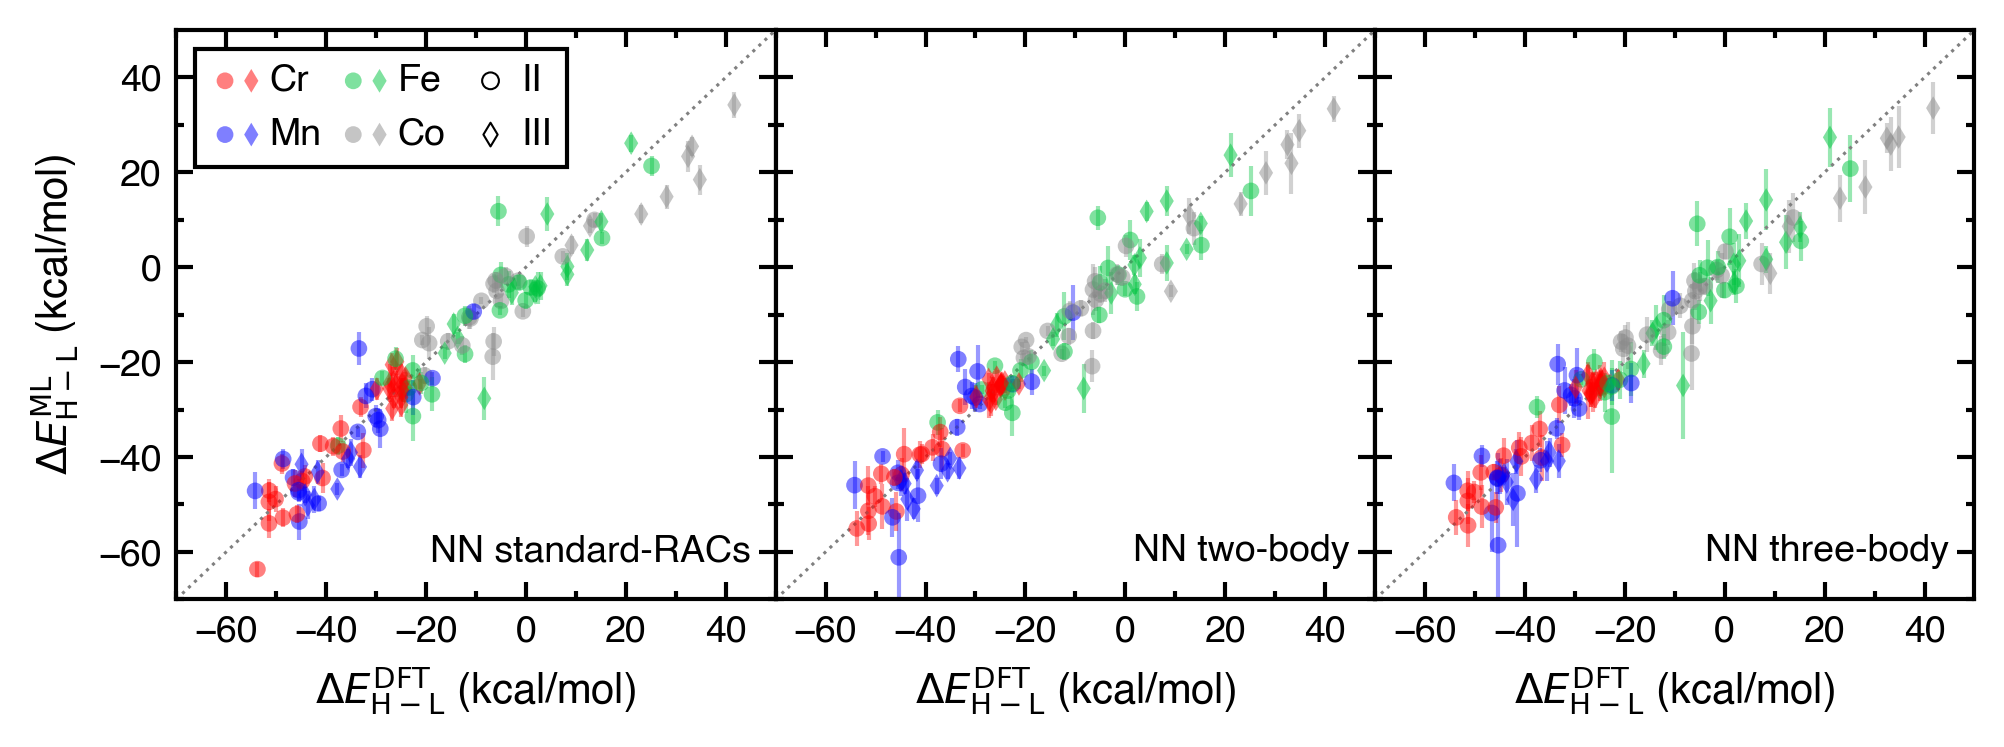

In [8]:
_, y = data_prep(df_lig_test, LigandFeatures.STANDARD_RACS, TargetProperty.SSE, False)
cores = df_lig_test[["metal", "ox"]].apply(lambda x: f"{x.metal}{x.ox}", axis=1).values

figsize = (6.66, 0.75 * 3.33)
fig = plt.figure(figsize=figsize)
gridspec_kw = {
    "left": 0.08,
    "right": 0.98,
    "top": 0.95,
    "bottom": 0.19,
    "hspace": 0.0,
    "wspace": 0.0,
}
axes = fig.subplots(
    ncols=3,
    nrows=1,
    sharex=True,
    sharey=True,
    gridspec_kw=gridspec_kw,
)

scatter_kwargs = {"s": 16, "alpha": 0.5, "edgecolors": "none"}
errorbar_kwargs = {"elinewidth": 1.0, "zorder": 0.0, "alpha": 0.4}
lower_lim = -70
upper_lim = 50

for experiment, ax in zip(nn_experiments, axes.flatten()):
    colors = np.array([color_dict[core[:2]] for core in cores])
    markers = np.array([marker_dict[core[-1]] for core in cores])
    scatter_random_z(
        ax,
        y,
        experiment.prediction,
        colors=colors,
        markers=markers,
        yerr=2.0 * experiment.uncertainty.flatten(),
        errorbar_kwargs=errorbar_kwargs,
        **scatter_kwargs,
    )
    # Plot parity line:
    ax.plot(
        [lower_lim, upper_lim],
        [lower_lim, upper_lim],
        color="0.5",
        linewidth=0.75,
        zorder=0.5,
        linestyle=":",
    )
    # Set limits and ticks
    ax.set_xlim([lower_lim, upper_lim])
    ax.set_ylim([lower_lim, upper_lim])
    ax.set_xticks(10 * np.arange(lower_lim // 10, upper_lim // 10), minor=True)
    ax.set_yticks(10 * np.arange(lower_lim // 10, upper_lim // 10), minor=True)
    ax.set_xticks([-60, -40, -20, 0, 20, 40])


axes[0].set_ylabel("$\Delta E^\mathrm{ML}_{\mathrm{H}-\mathrm{L}}$ (kcal/mol)")
for ax in axes:
    ax.set_xlabel("$\Delta E^\mathrm{DFT}_{\mathrm{H}-\mathrm{L}}$ (kcal/mol)")

for i, label in enumerate(["NN standard-RACs", "NN two-body", "NN three-body"]):
    axes[i].text(45, -60, label, fontsize=9, ha="right", va="center")

# Legend
core_legend(
    axes[0],
    legend_kwargs=dict(
        loc="upper left",
        bbox_to_anchor=[0.0, 1.0],
        markerscale=0.9,
        handletextpad=0.08,
        columnspacing=0.45,
        ncols=3,
    ),
)

fig.savefig("plots/parity_plot_sse_lig_test_alt.pdf")

# Outliers

In [9]:
for experiment in krr_experiments:
    print(f"Largest outliers 5 for {experiment.name}:")
    inds = np.argsort(abs(experiment.prediction.flatten() - y.flatten()))
    for ind in reversed(inds[-5:]):
        print(ind, df_lig_test.iloc[ind]["name"], experiment.prediction[ind], y[ind, 0])

Largest outliers 5 for krr_standard_racs:
25 co_3_bipyrimidine_bipyrimidine_bipyrimidine_bipyrimidine_bipyrimidine_bipyrimidine [13.48417307] 33.26005005606743
36 fe_2_[PH]=[CH]-[OH]_[PH]=[CH]-[OH]_[PH]=[CH]-[OH]_[PH]=[CH]-[OH]_[PH]=[CH]-[OH]_[PH]=[CH]-[OH] [13.04570859] -5.504143878553484
58 fe_3_bipyrimidine_bipyrimidine_bipyrimidine_bipyrimidine_bipyrimidine_bipyrimidine [-3.31231066] 12.273610786561564
114 cr_3_[PH]=[CH]-[OH]_[PH]=[CH]-[OH]_[PH]=[CH]-[OH]_[PH]=[CH]-[OH]_[PH]=[CH]-[OH]_[PH]=[CH]-[OH] [-37.97342576] -24.08122450376618
82 mn_3_1H-tetrazole_1H-tetrazole_1H-tetrazole_1H-tetrazole_1H-tetrazole_1H-tetrazole [-45.77120078] -33.21712025042509
Largest outliers 5 for krr_two_body:
36 fe_2_[PH]=[CH]-[OH]_[PH]=[CH]-[OH]_[PH]=[CH]-[OH]_[PH]=[CH]-[OH]_[PH]=[CH]-[OH]_[PH]=[CH]-[OH] [20.0926121] -5.504143878553484
79 mn_2_thiane_thiane_thiane_thiane_thiane_thiane [-24.65684866] -45.36123171873706
25 co_3_bipyrimidine_bipyrimidine_bipyrimidine_bipyrimidine_bipyrimidine_bipyrimidine 

In [10]:
for experiment in nn_experiments:
    print(f"Largest outliers 5 for {experiment.name}:")
    inds = np.argsort(abs(experiment.prediction.flatten() - y.flatten()))
    for ind in reversed(inds[-5:]):
        print(ind, df_lig_test.iloc[ind]["name"], experiment.prediction[ind], y[ind, 0])

Largest outliers 5 for nn_standard_racs:
61 fe_3_thiane_thiane_thiane_thiane_thiane_thiane [-27.645145] -8.33700289321462
36 fe_2_[PH]=[CH]-[OH]_[PH]=[CH]-[OH]_[PH]=[CH]-[OH]_[PH]=[CH]-[OH]_[PH]=[CH]-[OH]_[PH]=[CH]-[OH] [11.786443] -5.504143878553484
21 co_3_1H-tetrazole_1H-tetrazole_1H-tetrazole_1H-tetrazole_1H-tetrazole_1H-tetrazole [18.448776] 34.81876206569386
70 mn_2_[PH]=[CH]-[OH]_[PH]=[CH]-[OH]_[PH]=[CH]-[OH]_[PH]=[CH]-[OH]_[PH]=[CH]-[OH]_[PH]=[CH]-[OH] [-17.133795] -33.44037186870462
28 co_3_thioazole_thioazole_thioazole_thioazole_thioazole_thioazole [14.8581085] 28.16267771088611
Largest outliers 5 for nn_two_body:
61 fe_3_thiane_thiane_thiane_thiane_thiane_thiane [-25.536337] -8.33700289321462
36 fe_2_[PH]=[CH]-[OH]_[PH]=[CH]-[OH]_[PH]=[CH]-[OH]_[PH]=[CH]-[OH]_[PH]=[CH]-[OH]_[PH]=[CH]-[OH] [10.417119] -5.504143878553484
79 mn_2_thiane_thiane_thiane_thiane_thiane_thiane [-61.147484] -45.36123171873706
17 co_2_thiane_thiane_thiane_thiane_thiane_thiane [-20.864513] -6.6497752492